In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor # HGBR is a good modern efficient one
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor



In [2]:
!pip install catboost
!pip install --upgrade xgboost
!pip install h2o


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.9 MB/s eta 0:00:00


In [3]:
import h2o
import time

In [4]:
from catboost import CatBoostRegressor # Will be used later
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm.callback import early_stopping as lgb_early_stopping # Renamed to avoid potential conflicts


In [5]:
from sklearn.model_selection import train_test_split
from google.colab import files

uploaded = files.upload()

Saving tpu-gpu.csv to tpu-gpu.csv


In [6]:
df = pd.read_csv('tpu-gpu.csv')


In [7]:
df.head()

,Public ID,Organization,Availability,System Name (click + for details),# of Nodes,Processor,Accelerator,# of Accelerators,Benchmark,Model MLC,Scenario,Units,Valid / Invalid,# of Accelerators.1,# of Nodes.1,Accelerator.1,Availability.1,Host Processor Core Count,Processor.1,Avg. Result at System Name
0,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama2-70b-99,Offline,Tokens/s,NaN,8,1,AMD Instinct MI325X 256GB HBM3E,available,64,AMD EPYC 9575F,33928.1000
1,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama2-70b-99,Server,Tokens/s,NaN,8,1,AMD Instinct MI325X 256GB HBM3E,available,64,AMD EPYC 9575F,30724.5100
2,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama2-70b-99.9,Offline,Tokens/s,NaN,8,1,AMD Instinct MI325X 256GB HBM3E,available,64,AMD EPYC 9575F,33928.1000
3,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama2-70b-99.9,Server,Tokens/s,NaN,8,1,AMD Instinct MI325X 256GB HBM3E,available,64,AMD EPYC 9575F,30724.5100
4,5.0-0002,AMD,available,Quanta S7PA,1,2xAMD EPYC 9655,AMD Instinct MI325X 256GB HBM3E,8,Inference,stable-diffusion-xl,Offline,Samples/s,NaN,8,1,AMD Instinct MI325X 256GB HBM3E,available,0,2xAMD EPYC 9655,17.0963


In [8]:
df.shape

(861, 20)

In [9]:
df.describe(include='all')  # Understand numerical & categorical columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Public ID                          861 non-null    object 
 1   Organization                       861 non-null    object 
 2   Availability                       861 non-null    object 
 3   System Name (click + for details)  861 non-null    object 
 4   # of Nodes                         861 non-null    int64  
 5   Processor                          861 non-null    object 
 6   Accelerator                        812 non-null    object 
 7   # of Accelerators                  861 non-null    int64  
 8   Benchmark                          861 non-null    object 
 9   Model MLC                          861 non-null    object 
 10  Scenario                           861 non-null    object 
 11  Units                              861 non-null    object 

In [10]:
df["Model MLC"] = df["Model MLC"].str.lower().str.replace(r"[^a-z0-9]", "", regex=True)


In [11]:
df["CPU Type"] = df["Processor"].str.extract(r"(EPYC|Xeon|Core|Threadripper)")
df["GPU Type"] = df["Accelerator"].str.extract(r"(MI\d+|A\d+|H\d+|T\d+|RTX\d+)")

In [12]:
df["CPU Count"] = df["Processor"].str.extract(r"(\d+)x").fillna(1).astype(int)

In [13]:
df["Total Accelerators"] = df["# of Accelerators"].fillna(0).astype(int)


In [14]:
df.corr(numeric_only=True)["Avg. Result at System Name"].sort_values(ascending=False)


,Avg. Result at System Name
Avg. Result at System Name,1.000000
Total Accelerators,0.183417
# of Accelerators,0.183417
# of Accelerators.1,0.183417
# of Nodes.1,-0.016784
# of Nodes,-0.016784
CPU Count,-0.034571
Host Processor Core Count,-0.075668
Valid / Invalid,NaN


In [15]:
# ----- CPU Features -----
# Extract CPU generation number
df["cpu_generation"] = df["Processor"].str.extract(r'EPYC\s*(\d+)').astype(float)

# Detect dual socket systems
df["dual_socket"] = df["Processor"].str.contains("2x", na=False).astype(int)

# ----- GPU Features -----
# Extract GPU memory (in GB)
df["gpu_memory_gb"] = df["Accelerator"].str.extract(r'(\d+)GB').astype(float)

# Extract GPU type (3rd word in the string, e.g., MI325X)
df["gpu_type"] = df["Accelerator"].str.split().str[2]

# Total GPU memory = GPU memory × # of Accelerators
df["total_gpu_memory"] = df["gpu_memory_gb"] * df["# of Accelerators"]

# ----- Model Features -----
# Extract model family (e.g., 'llama2' from 'llama2-70b')
df["model_family"] = df["Model MLC"].astype(str).str.split("-").str[0]

# Extract model size in billions (e.g., 70 from '70b')
df["model_size_b"] = df["Model MLC"].astype(str).str.extract(r'(\d+)[bB]').astype(float)

# Categorize model type (basic heuristic: NLP, CV, Other)
df["model_type"] = "Other"
df.loc[df["Model MLC"].str.contains("llama|bert|gpt", case=False, na=False), "model_type"] = "NLP"
df.loc[df["Model MLC"].str.contains("diffusion|resnet|vit", case=False, na=False), "model_type"] = "CV"

# ----- Additional Features -----
# Accelerators per node
df["accelerators_per_node"] = df["# of Accelerators"] / df["# of Nodes"]

# Interaction feature: GPU memory × model size
df["GPU_Memory_x_ModelSize"] = df["gpu_memory_gb"] * df["model_size_b"]

# ----- Preview -----
print(df[[
    "cpu_generation", "dual_socket", "gpu_memory_gb", "gpu_type",
    "total_gpu_memory", "model_family", "model_size_b", "model_type",
    "accelerators_per_node", "GPU_Memory_x_ModelSize"
]].head())

   cpu_generation  dual_socket  gpu_memory_gb gpu_type  total_gpu_memory  \
0          9575.0            0          256.0   MI325X            2048.0   
1          9575.0            0          256.0   MI325X            2048.0   
2          9575.0            0          256.0   MI325X            2048.0   
3          9575.0            0          256.0   MI325X            2048.0   
4          9655.0            1          256.0   MI325X            2048.0   

        model_family  model_size_b model_type  accelerators_per_node  \
0        llama270b99         270.0        NLP                    8.0   
1        llama270b99         270.0        NLP                    8.0   
2       llama270b999         270.0        NLP                    8.0   
3       llama270b999         270.0        NLP                    8.0   
4  stablediffusionxl           NaN         CV                    8.0   

   GPU_Memory_x_ModelSize  
0                 69120.0  
1                 69120.0  
2                 69120.0 

In [16]:
df["Model MLC"].unique()

array(['llama270b99', 'llama270b999', 'stablediffusionxl', 'dlrmv299',
       'dlrmv2999', 'gptj99', 'gptj999', '3dunet99', '3dunet999',
       'resnet', 'retinanet', 'llama270binteractive99',
       'llama270binteractive999', 'llama31405b', 'mixtral8x7b', 'rgat'],
      dtype=object)

In [17]:
df.corr(numeric_only=True)["Avg. Result at System Name"].sort_values(ascending=False)


,Avg. Result at System Name
Avg. Result at System Name,1.000000
Total Accelerators,0.183417
# of Accelerators.1,0.183417
# of Accelerators,0.183417
accelerators_per_node,0.181713
total_gpu_memory,0.100510
cpu_generation,0.031088
gpu_memory_gb,-0.001710
# of Nodes,-0.016784
# of Nodes.1,-0.016784


In [18]:
df["memory_model_ratio"] = df["total_gpu_memory"] / df["model_size_b"]


In [19]:

df["log_model_size_b"] = np.log1p(df["model_size_b"])
df["log_gpu_memory_gb"] = np.log1p(df["gpu_memory_gb"])
df["log_total_gpu_memory"] = np.log1p(df["total_gpu_memory"])
df["log_cpu_cores"] = np.log1p(df["Host Processor Core Count"])

In [20]:
df["gpus_per_core"] = df["# of Accelerators"] / df["Host Processor Core Count"]
df["gpus_per_node"] = df["# of Accelerators"] / df["# of Nodes"]


In [21]:
# Example: extract quantization info from model name if present
df["model_precision"] = df["Model MLC"].str.extract(r'(int8|fp16|float16|bf16|fp32)')

In [22]:
df["is_server"] = (df["Scenario"] == "Server").astype(int)
df["is_offline"] = (df["Scenario"] == "Offline").astype(int)


In [23]:
df["gpu_vendor"] = df["Accelerator"].str.extract(r'^(NVIDIA|AMD|Intel)', expand=False)


In [24]:
df.corr(numeric_only=True)["Avg. Result at System Name"].sort_values(ascending=False)


,Avg. Result at System Name
Avg. Result at System Name,1.000000
memory_model_ratio,0.518090
Total Accelerators,0.183417
# of Accelerators,0.183417
# of Accelerators.1,0.183417
accelerators_per_node,0.181713
gpus_per_node,0.181713
gpus_per_core,0.149950
log_total_gpu_memory,0.131977
total_gpu_memory,0.100510


In [25]:
df.head()

,Public ID,Organization,Availability,System Name (click + for details),# of Nodes,Processor,Accelerator,# of Accelerators,Benchmark,Model MLC,...,log_model_size_b,log_gpu_memory_gb,log_total_gpu_memory,log_cpu_cores,gpus_per_core,gpus_per_node,model_precision,is_server,is_offline,gpu_vendor
0,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama270b99,...,5.602119,5.549076,7.625107,4.174387,0.125,8.0,NaN,0,1,AMD
1,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama270b99,...,5.602119,5.549076,7.625107,4.174387,0.125,8.0,NaN,1,0,AMD
2,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama270b999,...,5.602119,5.549076,7.625107,4.174387,0.125,8.0,NaN,0,1,AMD
3,5.0-0001,AMD,available,QuantaGrid D74A-7U,1,AMD EPYC 9575F,AMD Instinct MI325X 256GB HBM3E,8,Inference,llama270b999,...,5.602119,5.549076,7.625107,4.174387,0.125,8.0,NaN,1,0,AMD
4,5.0-0002,AMD,available,Quanta S7PA,1,2xAMD EPYC 9655,AMD Instinct MI325X 256GB HBM3E,8,Inference,stablediffusionxl,...,NaN,5.549076,7.625107,0.000000,inf,8.0,NaN,0,1,AMD


In [26]:
df["cpu_cores_x_model_size"] = df["Host Processor Core Count"] * df["model_size_b"]

In [27]:
df["total_system_accelerators"] = df["# of Nodes"] * df["# of Accelerators"]

In [28]:
# Example: one-hot encode top N benchmarks
top_benchmarks = df['Benchmark'].value_counts().nlargest(5).index
for benchmark in top_benchmarks:
    df[f'benchmark_{benchmark.replace(" ", "_")}'] = (df['Benchmark'] == benchmark).astype(int)

In [29]:
df["system_vendor"] = df["System Name (click + for details)"].str.extract(r'^(Quanta|Supermicro|Dell|HPE|Lenovo)', expand=False)
# Then encode this categorical feature

In [30]:
df["cpu_cores_per_node"] = df["Host Processor Core Count"] / df["# of Nodes"]

In [31]:
df["gpu_memory_per_core"] = df["total_gpu_memory"] / df["Host Processor Core Count"]

In [32]:
df["total_gpu_memory_squared"] = df["total_gpu_memory"]**2

In [33]:
df.corr(numeric_only=True)["Avg. Result at System Name"].sort_values(ascending=False)


,Avg. Result at System Name
Avg. Result at System Name,1.000000
memory_model_ratio,0.518090
Total Accelerators,0.183417
# of Accelerators.1,0.183417
# of Accelerators,0.183417
accelerators_per_node,0.181713
gpus_per_node,0.181713
gpus_per_core,0.149950
log_total_gpu_memory,0.131977
total_system_accelerators,0.102309


In [34]:
df["Avg. Result at System Name"].min()

1.26862

In [35]:
df["Avg. Result at System Name"].max()

773300.0

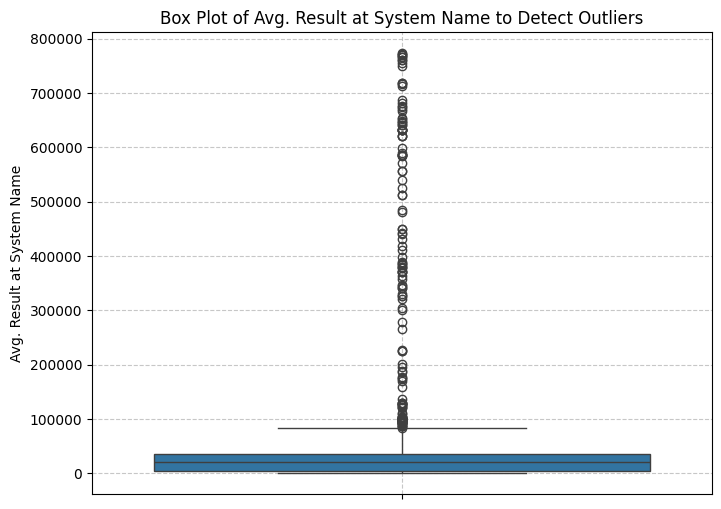

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df["Avg. Result at System Name"])
plt.title('Box Plot of Avg. Result at System Name to Detect Outliers')
plt.ylabel('Avg. Result at System Name')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

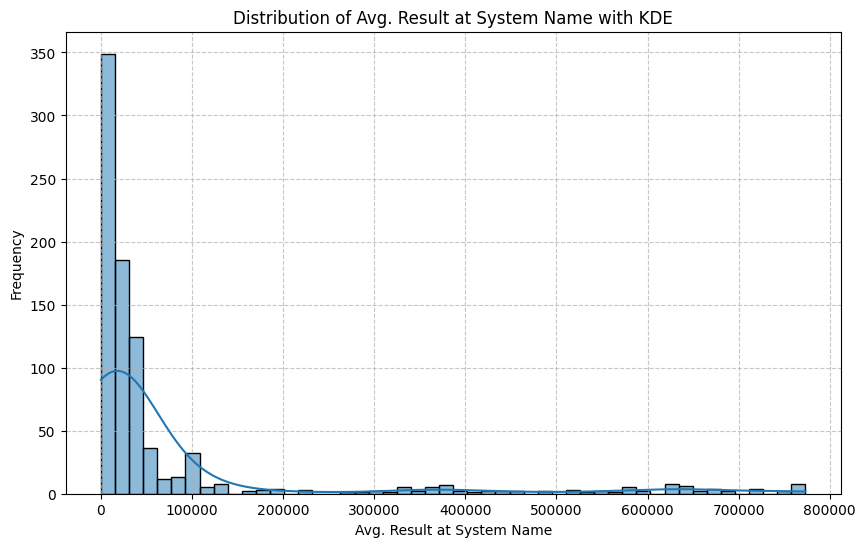

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Avg. Result at System Name"], kde=True, bins=50) # Adjust 'bins' as needed
plt.title('Distribution of Avg. Result at System Name with KDE')
plt.xlabel('Avg. Result at System Name')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

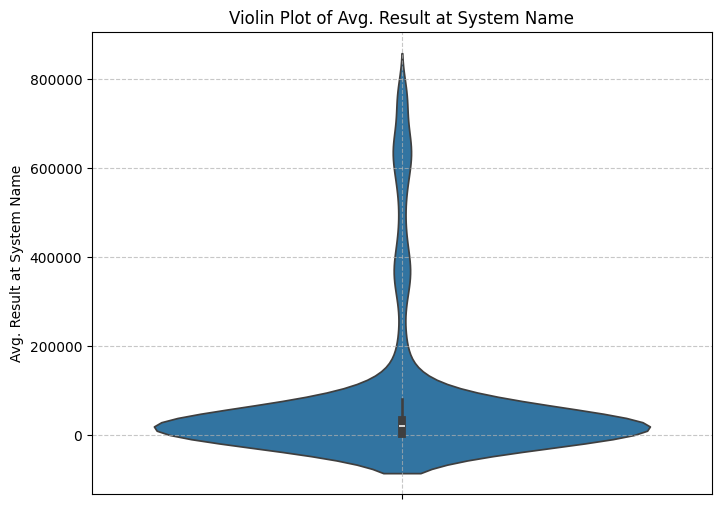

In [38]:
plt.figure(figsize=(8, 6))
sns.violinplot(y=df["Avg. Result at System Name"])
plt.title('Violin Plot of Avg. Result at System Name')
plt.ylabel('Avg. Result at System Name')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

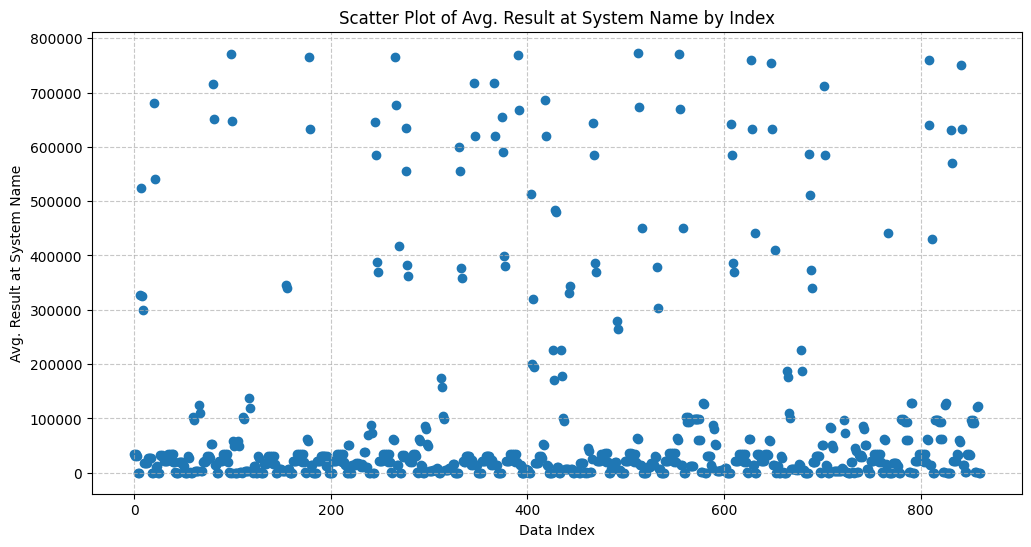

In [39]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df["Avg. Result at System Name"])
plt.title('Scatter Plot of Avg. Result at System Name by Index')
plt.xlabel('Data Index')
plt.ylabel('Avg. Result at System Name')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [40]:
df[df["Avg. Result at System Name"]>250000]["Avg. Result at System Name"].count()

np.int64(85)

In [41]:
df["Avg. Result at System Name"].count()

np.int64(861)

## Label ending features

In [42]:
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
print(f"Identified categorical columns for Label Encoding: {categorical_cols}")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()

    # Fit and transform the entire column
    encoded_values = le.fit_transform(df[col])

    # Create a new column name for the encoded feature
    new_col_name = f"{col}_encoded"

    # Add the new encoded column to your original df
    df[new_col_name] = encoded_values

    label_encoders[col] = le # Store the fitted encoder (optional, but good practice)

print("\n--- DataFrame after adding Label Encoded columns ---")
# Display head with some original and new encoded columns
print(df[categorical_cols + [f"{col}_encoded" for col in categorical_cols]].head())
print("\n--- df.info() (showing new encoded columns and their dtypes) ---")
df.info()


Identified categorical columns for Label Encoding: ['Public ID', 'Organization', 'Availability', 'System Name (click + for details)', 'Processor', 'Accelerator', 'Benchmark', 'Model MLC', 'Scenario', 'Units', 'Accelerator.1', 'Availability.1', 'Processor.1', 'CPU Type', 'GPU Type', 'gpu_type', 'model_family', 'model_type', 'model_precision', 'gpu_vendor', 'system_vendor']

--- DataFrame after adding Label Encoded columns ---
  Public ID Organization Availability System Name (click + for details)  \
0  5.0-0001          AMD    available                QuantaGrid D74A-7U   
1  5.0-0001          AMD    available                QuantaGrid D74A-7U   
2  5.0-0001          AMD    available                QuantaGrid D74A-7U   
3  5.0-0001          AMD    available                QuantaGrid D74A-7U   
4  5.0-0002          AMD    available                       Quanta S7PA   

         Processor                      Accelerator  Benchmark  \
0   AMD EPYC 9575F  AMD Instinct MI325X 256GB HBM3E  I

In [43]:
df.corr(numeric_only=True)["Avg. Result at System Name"].sort_values(ascending=False)

,Avg. Result at System Name
Avg. Result at System Name,1.000000
memory_model_ratio,0.518090
Total Accelerators,0.183417
# of Accelerators,0.183417
# of Accelerators.1,0.183417
accelerators_per_node,0.181713
gpus_per_node,0.181713
gpus_per_core,0.149950
log_total_gpu_memory,0.131977
gpu_type_encoded,0.108167


### Devide Train, Validation and Test

In [44]:
# Define columns to always exclude from features
target_column = 'Avg. Result at System Name'
EXCLUDE_COLS = [
    target_column,
    'Valid / Invalid', # Entirely null, useless
    'Public ID',       # Identifier, not a feature
    'Public ID_encoded' # Encoded identifier, not a feature
]

# --- 1. Define Features (X) and Target (y) for models requiring numerical input ---

# Identify the original string categorical columns that we *intend* to use as features for CatBoost
# Filter out those in EXCLUDE_COLS
categorical_cols_original = [
    col for col in df.columns
    if df[col].dtype == 'object' and col not in EXCLUDE_COLS
]

# Select all columns that are numerical types (int, float, bool)
X_cols_for_numeric_models = df.select_dtypes(include=[np.number, np.bool_]).columns.tolist()

# Now, filter out the columns we explicitly want to exclude
X_cols_for_numeric_models = [col for col in X_cols_for_numeric_models if col not in EXCLUDE_COLS]

# Create the X DataFrame containing only the desired numerical features
X = df[X_cols_for_numeric_models]
y = df[target_column]

print("Columns in X for numerical models (should not contain 'object' Dtypes or IDs):")
print(X.columns.tolist()) # Print the list of columns
print("-" * 50)

# --- 2. Train/Validation/Test Split (using this new X and y) ---
# ... (this part of the code remains the same) ...
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print("-" * 50)




Columns in X for numerical models (should not contain 'object' Dtypes or IDs):
['# of Nodes', '# of Accelerators', '# of Accelerators.1', '# of Nodes.1', 'Host Processor Core Count', 'CPU Count', 'Total Accelerators', 'cpu_generation', 'dual_socket', 'gpu_memory_gb', 'total_gpu_memory', 'model_size_b', 'accelerators_per_node', 'GPU_Memory_x_ModelSize', 'memory_model_ratio', 'log_model_size_b', 'log_gpu_memory_gb', 'log_total_gpu_memory', 'log_cpu_cores', 'gpus_per_core', 'gpus_per_node', 'is_server', 'is_offline', 'cpu_cores_x_model_size', 'total_system_accelerators', 'benchmark_Inference', 'cpu_cores_per_node', 'gpu_memory_per_core', 'total_gpu_memory_squared', 'Organization_encoded', 'Availability_encoded', 'System Name (click + for details)_encoded', 'Processor_encoded', 'Accelerator_encoded', 'Benchmark_encoded', 'Model MLC_encoded', 'Scenario_encoded', 'Units_encoded', 'Accelerator.1_encoded', 'Availability.1_encoded', 'Processor.1_encoded', 'CPU Type_encoded', 'GPU Type_encoded',

--- Data Cleaning for Infinite Values ---
NaNs in X_train after replacing inf: 2818
NaNs in X_val after replacing inf: 568
NaNs in X_test after replacing inf: 545

--- Imputation Complete ---
NaNs remaining in X_train_imputed: 0
NaNs remaining in X_val_imputed: 0
NaNs remaining in X_test_imputed: 0
--------------------------------------------------

Training XGBoost...
XGBoost - Validation RMSE: 16191.0500, MAE: 4273.0256, R2: 0.9902
XGBoost - Test RMSE: 26189.2214, MAE: 6594.1514, R2: 0.9624

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 40
[LightGBM] [Warning] Found whitespace in feature_n

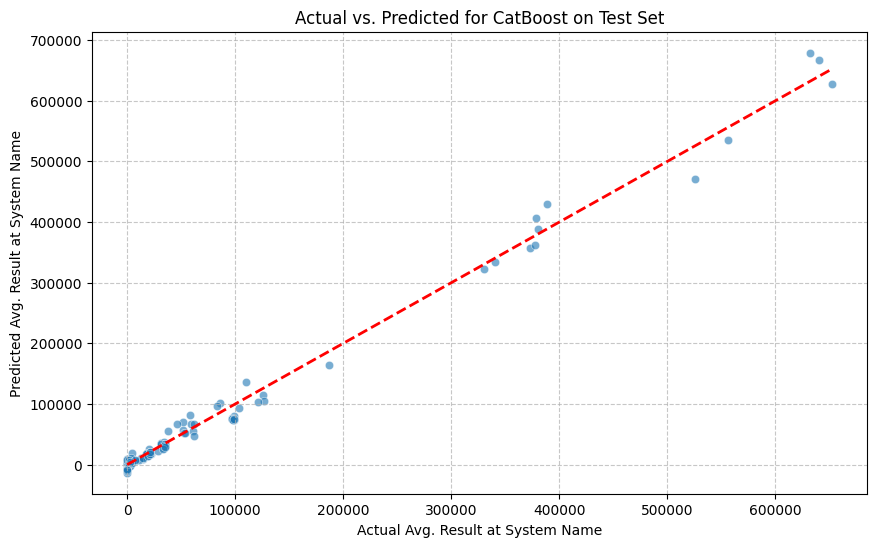

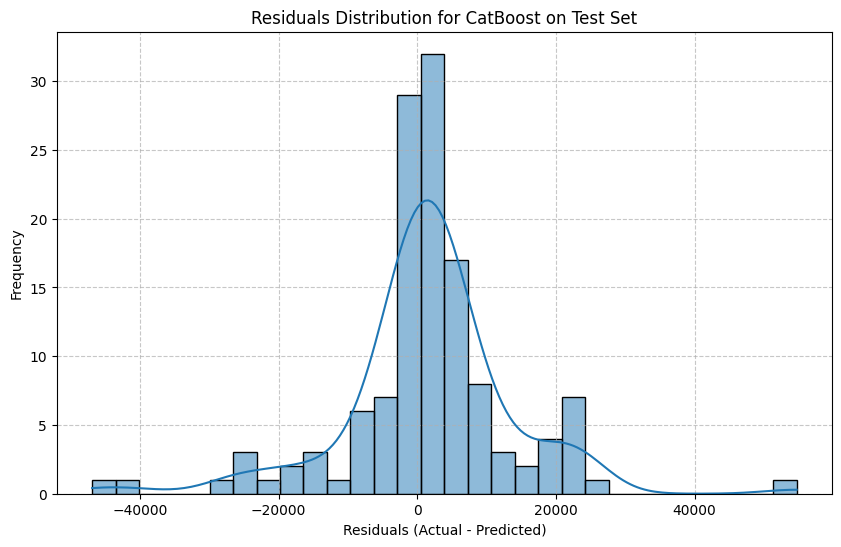

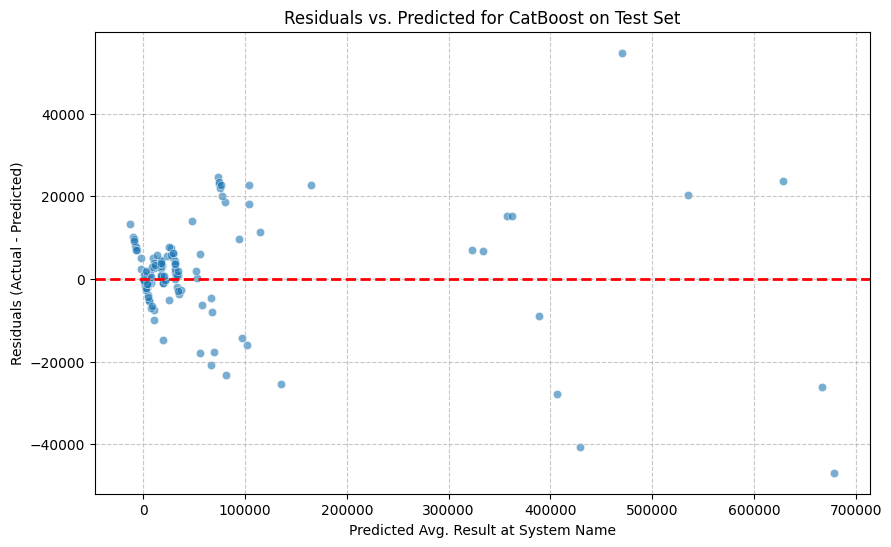

In [46]:
# ---  Model Training and Evaluation ---
print("--- Data Cleaning for Infinite Values ---")

# Replace any infinite values (positive or negative) with NaN across all sets
# We do this first so the imputer can then handle these NaNs.
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if any NaNs exist after replacing inf
print(f"NaNs in X_train after replacing inf: {X_train.isnull().sum().sum()}")
print(f"NaNs in X_val after replacing inf: {X_val.isnull().sum().sum()}")
print(f"NaNs in X_test after replacing inf: {X_test.isnull().sum().sum()}")


# Impute missing values (which now include replaced `inf` values)
# It's crucial to fit the imputer ONLY on the training data to prevent data leakage.
imputer = SimpleImputer(strategy='mean') # You can choose 'median' or 'most_frequent'

# Fit on training data and transform all data sets
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print("\n--- Imputation Complete ---")
print(f"NaNs remaining in X_train_imputed: {X_train_imputed.isnull().sum().sum()}") # Should be 0
print(f"NaNs remaining in X_val_imputed: {X_val_imputed.isnull().sum().sum()}")   # Should be 0
print(f"NaNs remaining in X_test_imputed: {X_test_imputed.isnull().sum().sum()}") # Should be 0
print("-" * 50)


# --- Update your model training loop to use the imputed data ---
# Replace X_train, X_val, X_test with X_train_imputed, X_val_imputed, X_test_imputed
# in the training and prediction steps for XGBoost, LightGBM, and HistGradientBoostingRegressor.

models = {
    "XGBoost": XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05, n_jobs=-1,
                            eval_metric='rmse'),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=1000, learning_rate=0.01, n_jobs=-1,
                              num_leaves=20),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(random_state=42, max_iter=500, learning_rate=0.05),
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42, n_estimators=500, n_jobs=-1),
    "MLPRegressor": MLPRegressor(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50), early_stopping=True, n_iter_no_change=20)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == "XGBoost":
        model.fit(X_train_imputed, y_train, # Use imputed data here
                  eval_set=[(X_val_imputed, y_val)], # Use imputed data here
                  verbose=False)
    elif name == "LightGBM":
        model.fit(X_train_imputed, y_train, # Use imputed data here
                  eval_set=[(X_val_imputed, y_val)], # Use imputed data here
                  callbacks=[lgb_early_stopping(stopping_rounds=50, verbose=False)])
    elif name in ["RandomForestRegressor", "ExtraTreesRegressor", "HistGradientBoostingRegressor", "MLPRegressor"]:
        model.fit(X_train_imputed, y_train)
    else:
        # This 'else' block should ideally not be hit if all models are handled.
        # This is a safeguard if you add models not specifically handled above.
        print(f"Warning: Model {name} not explicitly handled in fit logic. Attempting default fit.")
        model.fit(X_train_imputed, y_train)

    # Evaluate on Validation Set
    y_val_pred = model.predict(X_val_imputed) # Use imputed data here
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Evaluate on Test Set
    y_test_pred = model.predict(X_test_imputed) # Use imputed data here
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results[name] = {
        "Validation RMSE": val_rmse,
        "Validation MAE": val_mae,
        "Validation R2": val_r2,
        "Test RMSE": test_rmse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    }
    print(f"{name} - Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R2: {val_r2:.4f}")
    print(f"{name} - Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# ---  Compare Results ---
results_df = pd.DataFrame(results).T
print("\n--- Model Comparison Results (Validation & Test Sets) ---")
print(results_df.sort_values(by="Test RMSE")) # Sort by Test RMSE, lower is better

# --- 5. CatBoost Model ---
print("\n--- Training CatBoost Model ---")

# Start by dropping the target and all _encoded columns
X_cat = df.drop(columns=[target_column] + [col for col in df.columns if col.endswith('_encoded')], errors='ignore')

# Also drop other explicitly excluded original columns (like Public ID, Valid / Invalid, System Name)
X_cat = X_cat.drop(columns=[col for col in EXCLUDE_COLS if col in X_cat.columns and not col.endswith('_encoded')], errors='ignore')

y_cat = df[target_column]

# Identify the categorical features for CatBoost
cat_features_for_catboost = [col for col in X_cat.columns if col in categorical_cols_original]

# *** THIS IS THE ONLY PART TO CHANGE FOR CATBOOST NAN HANDLING ***
# Explicitly fill NaNs in the identified categorical columns for CatBoost
for col in cat_features_for_catboost:
    if X_cat[col].isnull().any(): # Check if the column actually has NaNs
        X_cat[col] = X_cat[col].fillna('__MISSING__') # Fill with a placeholder string

# Verify that no NaNs remain in the categorical columns (optional, but good for debugging)
for col in cat_features_for_catboost:
    if X_cat[col].isnull().any():
        print(f"Warning: NaN values still found in categorical column '{col}' for CatBoost after filling.")


# Re-split the data for CatBoost to ensure X_train_cat etc. have the original string features
X_train_cat, X_temp_cat, y_train_cat, y_temp_cat = train_test_split(X_cat, y_cat, test_size=0.30, random_state=42)
X_val_cat, X_test_cat, y_val_cat, y_test_cat = train_test_split(X_temp_cat, y_temp_cat, test_size=0.50, random_state=42)

# CatBoost Model Training
model_catboost = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=False,
    cat_features=cat_features_for_catboost # Pass the list of categorical feature names
)

model_catboost.fit(
    X_train_cat, y_train_cat,
    eval_set=(X_val_cat, y_val_cat),
    early_stopping_rounds=50, # CatBoost uses early_stopping_rounds directly
    verbose_eval=False # Set to True to see evaluation logs during training
)


# Evaluate CatBoost on Test Set
y_test_pred_catboost = model_catboost.predict(X_test_cat)
test_rmse_catboost = np.sqrt(mean_squared_error(y_test_cat, y_test_pred_catboost))
test_mae_catboost = mean_absolute_error(y_test_cat, y_test_pred_catboost)
test_r2_catboost = r2_score(y_test_cat, y_test_pred_catboost)

results["CatBoost"] = {
    "Validation RMSE": model_catboost.get_best_score()['validation']['RMSE'],
    "Validation MAE": mean_absolute_error(y_val_cat, model_catboost.predict(X_val_cat)),
    "Validation R2": r2_score(y_val_cat, model_catboost.predict(X_val_cat)),
    "Test RMSE": test_rmse_catboost,
    "Test MAE": test_mae_catboost,
    "Test R2": test_r2_catboost
}
print(f"\nCatBoost - Test RMSE: {test_rmse_catboost:.4f}, MAE: {test_mae_catboost:.4f}, R2: {test_r2_catboost:.4f}")

# Final comparison including CatBoost
results_df_final = pd.DataFrame(results).T
print("\n--- Final Model Comparison Results (Validation & Test Sets) ---")
print(results_df_final.sort_values(by="Test RMSE")) # Sort by Test RMSE, lower is better


# --- 6. Visualizing Predictions (Optional) ---
# Choose your best performing model from the results_df_final for plotting
best_model_name = results_df_final.loc[results_df_final['Test RMSE'].idxmin()].name
print(f"\nPlotting predictions for the best model: {best_model_name}")

# Re-run prediction for the best model on test set for plotting
if best_model_name == "CatBoost":
    y_test_pred_best = model_catboost.predict(X_test_cat)
    y_test_actual = y_test_cat
else:
    best_model = models[best_model_name]
    y_test_pred_best = best_model.predict(X_test)
    y_test_actual = y_test

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_test_pred_best, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel("Actual Avg. Result at System Name")
plt.ylabel("Predicted Avg. Result at System Name")
plt.title(f"Actual vs. Predicted for {best_model_name} on Test Set")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = y_test_actual - y_test_pred_best
sns.histplot(residuals, kde=True, bins=30)
plt.title(f"Residuals Distribution for {best_model_name} on Test Set")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred_best, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Avg. Result at System Name")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residuals vs. Predicted for {best_model_name} on Test Set")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [50]:
# --- AUTOML FRAMEWORKS EXECUTION ---
print("\n--- Running AutoML Frameworks ---")


# --- H2O ---
print("\nInitializing H2O cluster (this may take a moment)...")
start_time = time.time()
try:
    h2o.init(nthreads=-1) # Initialize H2O cluster using all available threads

    # Convert pandas DataFrames to H2OFrame
    h2o_train_df = h2o.H2OFrame(pd.concat([X_train_imputed, y_train], axis=1))
    h2o_val_df = h2o.H2OFrame(pd.concat([X_val_imputed, y_val], axis=1))
    h2o_test_df = h2o.H2OFrame(pd.concat([X_test_imputed, y_test], axis=1)) # Need y_test for evaluation if it was used in H2O predict

    # Define predictors (features) and response (target)
    predictors = X_train_imputed.columns.tolist()
    response = target_column

    # Identify categorical columns in H2OFrame (H2O can auto-detect, but explicit is safer)
    # H2O will treat all numeric columns as numeric unless specified.
    # Since we imputed, all are numeric, so no need for specific categorical handling here
    # if the original categoricals were one-hot encoded or label encoded.
    # If using original categoricals, you'd mark them as 'enum':
    # for col in categorical_cols_original:
    #     if col in h2o_train_df.columns:
    #         h2o_train_df[col] = h2o_train_df[col].asfactor()
    #         h2o_val_df[col] = h2o_val_df[col].asfactor()
    #         h2o_test_df[col] = h2o_test_df[col].asfactor()

    from h2o.automl import H2OAutoML
    aml = H2OAutoML(max_models=10, # Max number of models to train
                    seed=42,
                    max_runtime_secs=300) # 5 minutes for demonstration; increase for better results

    aml.train(x=predictors, y=response, training_frame=h2o_train_df, validation_frame=h2o_val_df)

    # Get the best model from AutoML
    h2o_best_model = aml.leader

    # Evaluate on Validation Set
    h2o_y_val_pred = h2o_best_model.predict(h2o_val_df).as_data_frame().values.flatten()
    h2o_val_rmse = np.sqrt(mean_squared_error(y_val, h2o_y_val_pred))
    h2o_val_mae = mean_absolute_error(y_val, h2o_y_val_pred)
    h2o_val_r2 = r2_score(y_val, h2o_y_val_pred)

    # Evaluate on Test Set
    h2o_y_test_pred = h2o_best_model.predict(h2o_test_df).as_data_frame().values.flatten()
    h2o_test_rmse = np.sqrt(mean_squared_error(y_test, h2o_y_test_pred))
    h2o_test_mae = mean_absolute_error(y_test, h2o_y_test_pred)
    h2o_test_r2 = r2_score(y_test, h2o_y_test_pred)

    results['H2O_AutoML'] = {
        "Validation RMSE": h2o_val_rmse,
        "Validation MAE": h2o_val_mae,
        "Validation R2": h2o_val_r2,
        "Test RMSE": h2o_test_rmse,
        "Test MAE": h2o_test_mae,
        "Test R2": h2o_test_r2
    }
    print(f"H2O AutoML - Validation RMSE: {h2o_val_rmse:.4f}, MAE: {h2o_val_mae:.4f}, R2: {h2o_val_r2:.4f}")
    print(f"H2O AutoML - Test RMSE: {h2o_test_rmse:.4f}, MAE: {h2o_test_mae:.4f}, R2: {h2o_test_r2:.4f}")

except Exception as e:
    print(f"H2O AutoML training failed: {e}")
    print("Please ensure H2O is installed and the H2O cluster can be initialized.")
finally:
    h2o.cluster().shutdown(prompt=False) # Shut down H2O cluster cleanly
    print(f"H2O execution time: {time.time() - start_time:.2f} seconds")



--- Running AutoML Frameworks ---

Initializing H2O cluster (this may take a moment)...
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx51uvs5b
  JVM stdout: /tmp/tmpx51uvs5b/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpx51uvs5b/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_unknownUser_50cdbv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
20:43:30.622: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
20:43:30.769: _train param, Dropping bad and constant columns: [Benchmark_encoded, benchmark_Inference, model_precision_encoded]

████
20:43:48.12: _train param, Dropping bad and constant columns: [Benchmark_encoded, benchmark_Inference, model_precision_encoded]

█
20:43:49.248: _train param, Dropping bad and constant columns: [Benchmark_encoded, benchmark_Inference, model_precision_encoded]


20:43:52.711: _train param,

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


H2O AutoML - Validation RMSE: 23331.5263, MAE: 7425.6725, R2: 0.9796
H2O AutoML - Test RMSE: 19566.2492, MAE: 7054.7390, R2: 0.9790
H2O session _sid_ae38 closed.
H2O execution time: 108.57 seconds



--- Feature Importance Analysis ---

--- XGBoost Feature Importances (Top 10) ---
                   Feature  Importance
19           gpus_per_core    0.282963
45      model_type_encoded    0.257784
35       Model MLC_encoded    0.132361
1        # of Accelerators    0.131026
17    log_total_gpu_memory    0.124215
10        total_gpu_memory    0.018962
9            gpu_memory_gb    0.013752
33     Accelerator_encoded    0.010535
13  GPU_Memory_x_ModelSize    0.008191
42        GPU Type_encoded    0.003427

--- LightGBM Feature Importances (Top 10) ---
                      Feature  Importance
35          Model MLC_encoded        4430
45         model_type_encoded         898
10           total_gpu_memory         888
37              Units_encoded         837
32          Processor_encoded         801
33        Accelerator_encoded         774
13     GPU_Memory_x_ModelSize         606
19              gpus_per_core         538
4   Host Processor Core Count         530
27        gpu_memory_

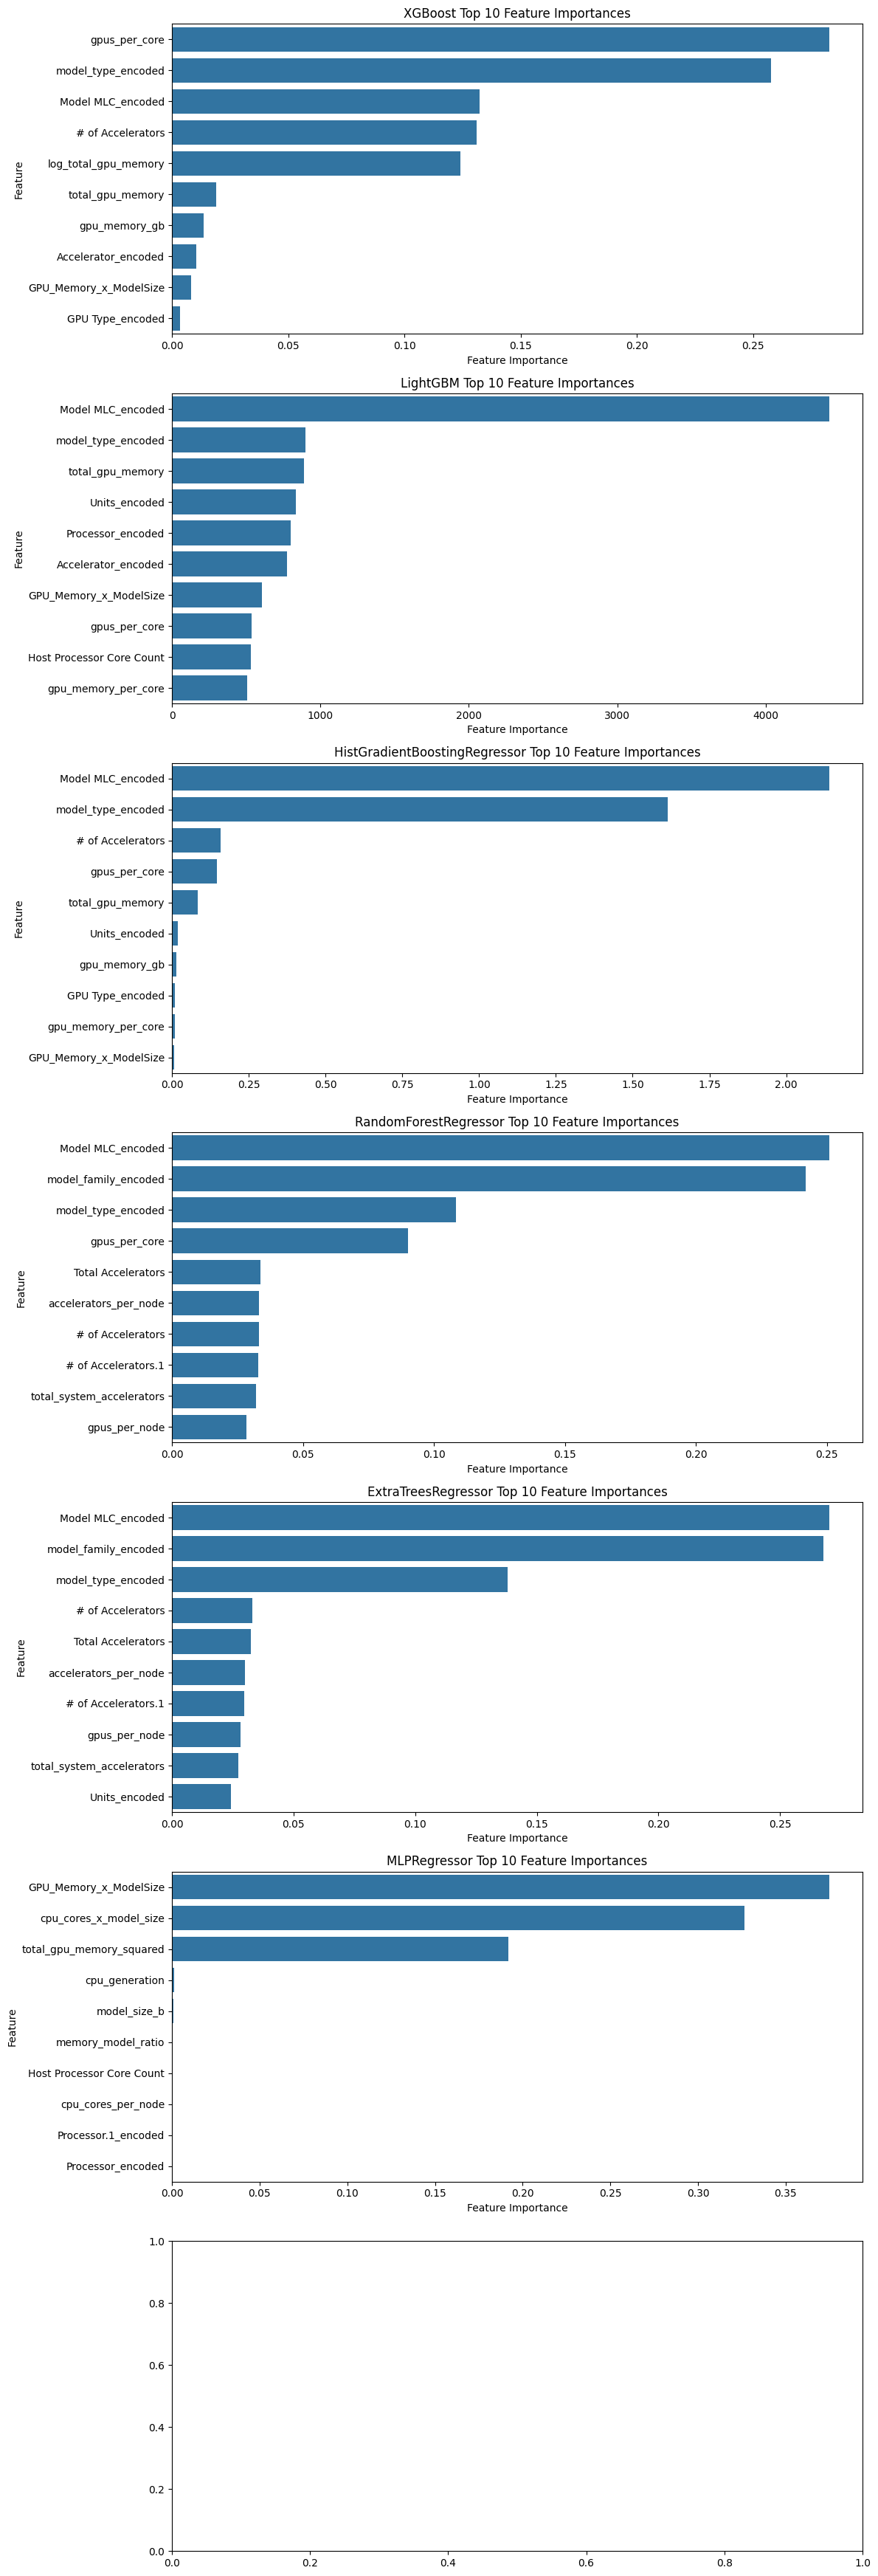

In [48]:
print("\n--- Feature Importance Analysis ---")

feature_importances_dict = {} # To store dataframes of importances for all models

# --- 1. XGBoost Feature Importance ---
# Assuming 'models' dictionary contains the trained XGBoost model
if 'XGBoost' in models and isinstance(models['XGBoost'], XGBRegressor):
    xgb_model = models['XGBoost']
    # Use columns from the imputed data which was fed to the model
    xgb_feature_names = X_train_imputed.columns.tolist()
    xgb_importances = xgb_model.feature_importances_
    xgb_importance_df = pd.DataFrame({
        'Feature': xgb_feature_names,
        'Importance': xgb_importances
    }).sort_values(by='Importance', ascending=False)
    feature_importances_dict['XGBoost'] = xgb_importance_df
    print("\n--- XGBoost Feature Importances (Top 10) ---")
    print(xgb_importance_df.head(10))
else:
    print("\nXGBoost model not found or not trained correctly for importance extraction.")

# --- 2. LightGBM Feature Importance ---
# Assuming 'models' dictionary contains the trained LightGBM model
if 'LightGBM' in models and isinstance(models['LightGBM'], LGBMRegressor):
    lgbm_model = models['LightGBM']
    lgbm_feature_names = X_train_imputed.columns.tolist()
    lgbm_importances = lgbm_model.feature_importances_
    lgbm_importance_df = pd.DataFrame({
        'Feature': lgbm_feature_names,
        'Importance': lgbm_importances
    }).sort_values(by='Importance', ascending=False)
    feature_importances_dict['LightGBM'] = lgbm_importance_df
    print("\n--- LightGBM Feature Importances (Top 10) ---")
    print(lgbm_importance_df.head(10))
else:
    print("\nLightGBM model not found or not trained correctly for importance extraction.")

# --- 3. HistGradientBoostingRegressor Feature Importance (Permutation Importance) ---
# This can be computationally intensive, especially on large datasets.
# We'll use the test set for robustness.
if 'HistGradientBoostingRegressor' in models and isinstance(models['HistGradientBoostingRegressor'], HistGradientBoostingRegressor):
    hist_model = models['HistGradientBoostingRegressor']
    print("\n--- Calculating HistGradientBoostingRegressor Permutation Importance (may take a moment) ---")
    # Use X_test_imputed for permutation importance calculation
    perm_importance = permutation_importance(
        hist_model, X_test_imputed, y_test,
        n_repeats=10,  # Number of times to permute a feature
        random_state=42,
        n_jobs=-1 # Use all available cores
    )
    hist_feature_names = X_test_imputed.columns.tolist()
    hist_importance_df = pd.DataFrame({
        'Feature': hist_feature_names,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)
    feature_importances_dict['HistGradientBoostingRegressor'] = hist_importance_df
    print("\n--- HistGradientBoostingRegressor Permutation Importances (Top 10) ---")
    print(hist_importance_df.head(10))
else:
    print("\nHistGradientBoostingRegressor model not found or not trained correctly for importance extraction.")

# --- 4. RandomForestRegressor Feature Importance ---
# Assuming 'models' dictionary contains the trained RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor # Ensure this import is present at the top
if 'RandomForestRegressor' in models and isinstance(models['RandomForestRegressor'], RandomForestRegressor):
    rf_model = models['RandomForestRegressor']
    rf_feature_names = X_train_imputed.columns.tolist()
    rf_importances = rf_model.feature_importances_ # Direct attribute for tree-based models
    rf_importance_df = pd.DataFrame({
        'Feature': rf_feature_names,
        'Importance': rf_importances
    }).sort_values(by='Importance', ascending=False)
    feature_importances_dict['RandomForestRegressor'] = rf_importance_df
    print("\n--- RandomForestRegressor Feature Importances (Top 10) ---")
    print(rf_importance_df.head(10))
else:
    print("\nRandomForestRegressor model not found or not trained correctly for importance extraction.")

# --- 5. ExtraTreesRegressor Feature Importance ---
# Assuming 'models' dictionary contains the trained ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor # Ensure this import is present at the top
if 'ExtraTreesRegressor' in models and isinstance(models['ExtraTreesRegressor'], ExtraTreesRegressor):
    et_model = models['ExtraTreesRegressor']
    et_feature_names = X_train_imputed.columns.tolist()
    et_importances = et_model.feature_importances_ # Direct attribute for tree-based models
    et_importance_df = pd.DataFrame({
        'Feature': et_feature_names,
        'Importance': et_importances
    }).sort_values(by='Importance', ascending=False)
    feature_importances_dict['ExtraTreesRegressor'] = et_importance_df
    print("\n--- ExtraTreesRegressor Feature Importances (Top 10) ---")
    print(et_importance_df.head(10))
else:
    print("\nExtraTreesRegressor model not found or not trained correctly for importance extraction.")

# --- 6. MLPRegressor Feature Importance (Permutation Importance) ---
# Assuming 'models' dictionary contains the trained MLPRegressor
from sklearn.neural_network import MLPRegressor # Ensure this import is present at the top
if 'MLPRegressor' in models and isinstance(models['MLPRegressor'], MLPRegressor):
    mlp_model = models['MLPRegressor']
    print("\n--- Calculating MLPRegressor Permutation Importance (may take a moment) ---")
    perm_importance_mlp = permutation_importance(
        mlp_model, X_test_imputed, y_test, # Use test set for unbiased importance
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    mlp_feature_names = X_test_imputed.columns.tolist()
    mlp_importance_df = pd.DataFrame({
        'Feature': mlp_feature_names,
        'Importance': perm_importance_mlp.importances_mean
    }).sort_values(by='Importance', ascending=False)
    feature_importances_dict['MLPRegressor'] = mlp_importance_df
    print("\n--- MLPRegressor Permutation Importances (Top 10) ---")
    print(mlp_importance_df.head(10))
else:
    print("\nMLPRegressor model not found or not trained correctly for importance extraction.")

# --- 7. CatBoost Feature Importance ---
# Assuming 'model_catboost' is the trained CatBoostRegressor object
if 'model_catboost' in locals() and isinstance(model_catboost, CatBoostRegressor):
    catboost_importances_df = model_catboost.get_feature_importance(
        prettified=True, # Returns a DataFrame with feature names
        thread_count=-1
    )
    feature_importances_dict['CatBoost'] = catboost_importances_df
    print("\n--- CatBoost Feature Importances (Top 10) ---")
    print(catboost_importances_df.head(10))
else:
    print("\nCatBoost model not found or not trained correctly for importance extraction.")

# --- Optional: Visualize Top Features (Example: plot top 10 for each model) ---
if feature_importances_dict: # Only proceed if there's data to plot
    # Determine number of rows needed for subplots
    num_models = len(feature_importances_dict)
    fig, axes = plt.subplots(num_models, 1, figsize=(12, 5 * num_models))
    axes = axes.flatten() if num_models > 1 else [axes] # Handle single plot case

    for i, (model_name, importance_df) in enumerate(feature_importances_dict.items()):
        if not importance_df.empty:
            # Ensure the DataFrame has 'Feature' and 'Importance' columns for plotting
            if 'Feature' in importance_df.columns and 'Importance' in importance_df.columns:
                plot_data = importance_df.head(10)
            elif 'variable' in importance_df.columns and 'percentage' in importance_df.columns: # For H2O varimp
                plot_data = importance_df.rename(columns={'variable': 'Feature', 'percentage': 'Importance'}).head(10)
            elif 'feature' in importance_df.columns and 'importance' in importance_df.columns: # Sometimes column names vary
                 plot_data = importance_df.rename(columns={'feature': 'Feature', 'importance': 'Importance'}).head(10)
            else:
                 print(f"Warning: Columns 'Feature' and 'Importance' not found in {model_name} importance data. Skipping plot for this model.")
                 continue

            sns.barplot(x='Importance', y='Feature', data=plot_data, ax=axes[i])
            axes[i].set_title(f'{model_name} Top 10 Feature Importances')
            axes[i].set_xlabel('Feature Importance')
            axes[i].set_ylabel('Feature')
        else:
            axes[i].set_title(f'{model_name} No Feature Importance Data Available')
            axes[i].text(0.5, 0.5, 'No data to display', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo feature importance data available to plot.")


In [51]:
# --- 8. H2O AutoML Feature Importance ---
# H2O's AutoML produces an ensemble. Getting importance for the ensemble is complex.
# We'll try to get importance for the LEADER model if it's a tree-based model.
if 'aml' in locals() and 'h2o_best_model' in locals():
    print("\n--- H2O AutoML Leader Model Feature Importances (if available) ---")
    try:
        # Check if the leader model supports feature importance (e.g., GBM, XGBoost, DRF)
        if hasattr(h2o_best_model, 'varimp') and callable(h2o_best_model.varimp):
            h2o_varimp = h2o_best_model.varimp(use_pandas=True)
            # H2O's varimp table columns: 'variable', 'relative_importance', 'scaled_importance', 'percentage'
            h2o_importance_df = h2o_varimp[['variable', 'percentage']].rename(columns={'variable': 'Feature', 'percentage': 'Importance'})
            feature_importances_dict['H2O_AutoML_Leader'] = h2o_importance_df.sort_values(by='Importance', ascending=False)
            print(feature_importances_dict['H2O_AutoML_Leader'].head(10))
        else:
            print(f"H2O leader model type ({h2o_best_model.algo}) does not directly expose feature importances via .varimp().")
            print("Consider using permutation importance on the leader model or specialized explainability tools for H2O AutoML ensembles.")

            # Optional: Fallback to permutation importance for H2O Leader Model if varimp is not available
            print("\nCalculating H2O Leader Model Permutation Importance (may take a moment)...")
            # For permutation_importance, we need pandas DataFrames, not H2OFrame.
            h2o_leader_perm_importance = permutation_importance(
                h2o_best_model, X_test_imputed, y_test,
                n_repeats=5, # Reduced repeats for speed, adjust as needed
                random_state=42,
                n_jobs=-1
            )
            h2o_leader_feature_names = X_test_imputed.columns.tolist()
            h2o_leader_importance_df = pd.DataFrame({
                'Feature': h2o_leader_feature_names,
                'Importance': h2o_leader_perm_importance.importances_mean
            }).sort_values(by='Importance', ascending=False)
            feature_importances_dict['H2O_AutoML_Leader_Permutation'] = h2o_leader_importance_df
            print(h2o_leader_importance_df.head(10))

    except Exception as e:
        print(f"Failed to get H2O AutoML leader model feature importance: {e}")
else:
    print("\nH2O AutoML not found or not trained successfully for importance extraction.")



--- H2O AutoML Leader Model Feature Importances (if available) ---
Failed to get H2O AutoML leader model feature importance: 'NoneType' object is not subscriptable
